# Notebook 08 — Final Report (Anforderungen 1–9)

**Projekt:** Vorhersage der Fahrtdauer von Fahrradaktivitäten (Regression)  
**Zielvariable:** `moving_time` (Sekunden)  
**Leakage-Regel:** `elapsed_time` wird **nicht** als Feature verwendet.

Dieses Notebook ist der zusammenführende Abschlussbericht und bildet die Anforderungen **1–9** in der vorgegebenen Reihenfolge ab:

1. Problembeschreibung  
2. Datenquelle & Datenbeschreibung  
3. Explorative Datenanalyse (EDA)  
4. Datenvorverarbeitung  
5. Data Augmentation (optional)  
6. Modellauswahl & -architektur  
7. Training  
8. Evaluation & Ergebnisse (inkl. Fehleranalyse)  
9. Diskussion & Fazit (Limitationen, Next Steps)

**Reproduzierbarkeit:**  
Notebook 08 lädt die Ergebnisse aus den Artefakten (`data_derived/`) und rechnet nur dort neu, wo es zur Darstellung/Validierung notwendig ist.

In [1]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / "data" / "processed").exists():
            return p
    return start

REPO_ROOT = find_repo_root(Path.cwd())

PATH_PROCESSED = REPO_ROOT / "data" / "processed" / "processed.csv"
PATH_MODEL_READY = REPO_ROOT / "data" / "processed" / "model_ready.csv"
PATH_DERIVED = REPO_ROOT / "data_derived"
PATH_PLOTS = REPO_ROOT / "plots"

PATH_DERIVED.mkdir(parents=True, exist_ok=True)
PATH_PLOTS.mkdir(parents=True, exist_ok=True)

def load_csv(path: Path, name: str) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(
            f"[ERROR] Artefakt fehlt: {name}\n"
            f"Erwarteter Pfad: {path}\n"
            "Bitte das entsprechende Notebook (01–07) ausführen."
        )
    return pd.read_csv(path)

def savefig(path: Path, dpi: int = 300) -> Path:
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    return path

print("REPO_ROOT:", REPO_ROOT)
print("processed.csv exists:", PATH_PROCESSED.exists(), "|", PATH_PROCESSED)
print("model_ready.csv exists:", PATH_MODEL_READY.exists(), "|", PATH_MODEL_READY)

REPO_ROOT: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer
processed.csv exists: True | /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data/processed/processed.csv
model_ready.csv exists: True | /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data/processed/model_ready.csv


In [2]:
ART = {
    "01_cleaning_report": PATH_DERIVED / "01_cleaning_report.csv",
    "02_scope_filter_report": PATH_DERIVED / "02_scope_filter_report.csv",
    "02_qc_summary_model_ready": PATH_DERIVED / "02_qc_summary_model_ready.csv",

    "03_cv_results_no_leak": PATH_DERIVED / "03_cv_results_final_no_leak.csv",
    "04_holdout_metrics_baseline": PATH_DERIVED / "04_holdout_metrics_no_leak.csv",
    "05_holdout_metrics_histgbr": PATH_DERIVED / "05_holdout_metrics_histgbr.csv",
    "05_comparison_baseline_vs_histgbr": PATH_DERIVED / "05_holdout_comparison_baseline_vs_histgbr.csv",
    "06_permutation_importance": PATH_DERIVED / "06_permutation_importance_histgbr.csv",

    "05_holdout_predictions_histgbr": PATH_DERIVED / "05_holdout_predictions_histgbr.csv",
}

missing = [k for k, p in ART.items() if not p.exists()]
if missing:
    raise FileNotFoundError(
        "[ERROR] Folgende Artefakte fehlen in data_derived/:\n- "
        + "\n- ".join([f"{k}: {ART[k].name}" for k in missing])
    )

cv = load_csv(ART["03_cv_results_no_leak"], "03_cv_results_final_no_leak.csv")
m_base = load_csv(ART["04_holdout_metrics_baseline"], "04_holdout_metrics_no_leak.csv")
m_hgbr = load_csv(ART["05_holdout_metrics_histgbr"], "05_holdout_metrics_histgbr.csv")
cmp = load_csv(ART["05_comparison_baseline_vs_histgbr"], "05_holdout_comparison_baseline_vs_histgbr.csv")

# ---- Robust CV column mapping (supports mae_mean or mae_mean_s variants) ----
def pick_col(df: pd.DataFrame, candidates: list[str]) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"[ERROR] Keine der erwarteten Spalten gefunden: {candidates}. Vorhanden: {df.columns.tolist()}")

cv_model_col = pick_col(cv, ["model", "Modell"])
cv_mae_col = pick_col(cv, ["mae_mean_s", "MAE_CV_mean_s", "mae_mean"])
cv_rmse_col = pick_col(cv, ["rmse_mean_s", "RMSE_CV_mean_s", "rmse_mean"])
cv_r2_col = pick_col(cv, ["r2_mean", "R2_CV_mean", "r2"])

cv_best = cv.sort_values(cv_mae_col, ascending=True).iloc[0]

executive_summary = pd.DataFrame([
    {
        "block": "CV (no-leak) – Baseline-Sieger",
        "model": str(cv_best[cv_model_col]),
        "mae_s": float(cv_best[cv_mae_col]),
        "rmse_s": float(cv_best[cv_rmse_col]),
        "r2": float(cv_best[cv_r2_col]),
        "mae_min": float(cv_best[cv_mae_col] / 60.0),
        "rmse_min": float(cv_best[cv_rmse_col] / 60.0),
    },
    {
        "block": "Hold-out – Baseline (no-leak)",
        "model": str(m_base.loc[0, "model"]),
        "mae_s": float(m_base.loc[0, "mae_s"]),
        "rmse_s": float(m_base.loc[0, "rmse_s"]),
        "r2": float(m_base.loc[0, "r2"]),
        "mae_min": float(m_base.loc[0, "mae_s"] / 60.0),
        "rmse_min": float(m_base.loc[0, "rmse_s"] / 60.0),
    },
    {
        "block": "Hold-out – Erweiterter Ansatz (HistGBR)",
        "model": str(m_hgbr.loc[0, "model"]),
        "mae_s": float(m_hgbr.loc[0, "mae_s"]),
        "rmse_s": float(m_hgbr.loc[0, "rmse_s"]),
        "r2": float(m_hgbr.loc[0, "r2"]),
        "mae_min": float(m_hgbr.loc[0, "mae_s"] / 60.0),
        "rmse_min": float(m_hgbr.loc[0, "rmse_s"] / 60.0),
    },
])

display(executive_summary)

exec_path = PATH_DERIVED / "80_executive_summary.csv"
executive_summary.to_csv(exec_path, index=False)
print("Saved:", exec_path)

impr_s = float(cmp.loc[0, "mae_improvement_s"])
impr_pct = float(cmp.loc[0, "mae_improvement_pct"])
print(f"Interpretation: HistGBR reduziert den Hold-out-MAE um {impr_s:.0f}s ({impr_pct:.1f}%).")

,block,model,mae_s,rmse_s,r2,mae_min,rmse_min
0,CV (no-leak) – Baseline-Sieger,"Ridge (degree=1, alpha=0.01) [BEST]",759.011044,1464.133160,0.918226,12.650184,24.402219
1,Hold-out – Baseline (no-leak),"Ridge (degree=1, alpha=0.01)",746.736998,1603.895606,0.907417,12.445617,26.731593
2,Hold-out – Erweiterter Ansatz (HistGBR),HistGBR depth=8 lr=0.05 it=300,583.163900,1412.426980,0.928202,9.719398,23.540450


Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/80_executive_summary.csv
Interpretation: HistGBR reduziert den Hold-out-MAE um 164s (21.9%).


## 1. Problembeschreibung

Ziel ist die **Vorhersage der Fahrtdauer** (`moving_time` in Sekunden) für Fahrradaktivitäten auf Basis weniger, vorab verfügbarer Merkmale (u. a. Distanz und Höhenmeter).  
Das Problem ist als **Regression** formuliert.

**Motivation:** Eine robuste Dauerprognose kann u. a. bei Tourenplanung, Trainingsanalyse und Erwartungsmanagement helfen.

**Herausforderungen (typisch für reale Aktivitätsdaten):**
- hohe Varianz insbesondere bei längeren Fahrten (Pausen, Routing, Gruppenfahrten)
- Mess- und Trackingartefakte (GPS, Stop-Erkennung)
- fehlende erklärende Variablen (Wetter, Fitness, Verkehr)

**Leakage-Regel:** Obwohl `elapsed_time` im Datensatz vorhanden ist, wird es nicht als Feature verwendet, da es Informationen enthält, die der Zielgröße sehr nahe stehen.

## 2. Datenquelle und Datenbeschreibung

**Quelle:** Kaggle-Datensatz “Outdoor cycling metrics” (User/Autor: dorinaferencsik).  
Die Rohdaten werden im Repository lokal als `data/raw/raw.csv` abgelegt und in diesem Projekt **nicht mitversioniert**.

**Lizenz / Nutzungsrechte:**  
Auf der Kaggle-Datensatzseite ist die Lizenz als **“License: unknown”** ausgewiesen.  
Daher wird der Datensatz im Rahmen dieser Projektarbeit ausschließlich zu Lehr- und Analysezwecken verwendet; eine Weiterverbreitung der Rohdaten über das Repository erfolgt nicht.

**Kurzbeschreibung der Daten:**
- Beobachtungen: einzelne Fahrradaktivitäten
- Zielvariable: `moving_time` (Sekunden)
- Enthaltene Merkmalsgruppen (Auszug): Distanz, Höhenmeter, Höhenlage sowie weitere Aktivitätsmetriken

In [3]:
processed = load_csv(PATH_PROCESSED, "processed.csv")
model_ready = load_csv(PATH_MODEL_READY, "model_ready.csv")

facts = pd.DataFrame([{
    "processed_rows": int(processed.shape[0]),
    "processed_cols": int(processed.shape[1]),
    "model_ready_rows": int(model_ready.shape[0]),
    "model_ready_cols": int(model_ready.shape[1]),
    "target_present_in_model_ready": int("moving_time" in model_ready.columns),
    "elapsed_time_present_in_model_ready": int("elapsed_time" in model_ready.columns),
}])

display(facts)

# Dokumentation der Leakage-Spalten
leakage_cols_present = [c for c in ["elapsed_time"] if c in model_ready.columns]
leak_path = PATH_DERIVED / "82_leakage_cols_present.csv"
pd.DataFrame({"leakage_col": leakage_cols_present}).to_csv(leak_path, index=False)
print("Saved:", leak_path)

print("Leakage-Spalten in model_ready (nicht als Feature nutzen):", leakage_cols_present)

,processed_rows,processed_cols,model_ready_rows,model_ready_cols,target_present_in_model_ready,elapsed_time_present_in_model_ready
0,9948,6,9237,13,1,1


Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/82_leakage_cols_present.csv
Leakage-Spalten in model_ready (nicht als Feature nutzen): ['elapsed_time']


## 3. Explorative Datenanalyse (EDA)

Ziel der EDA ist es, die Verteilungen und grundlegenden Zusammenhänge zu verstehen und daraus sinnvolle Modellierungsentscheidungen abzuleiten.

Im Fokus:
- Verteilung der Zielvariable `moving_time`
- Zusammenhang zwischen Distanz und Fahrtdauer
- Rangfolge der numerischen Merkmale nach Korrelation mit der Zielvariable

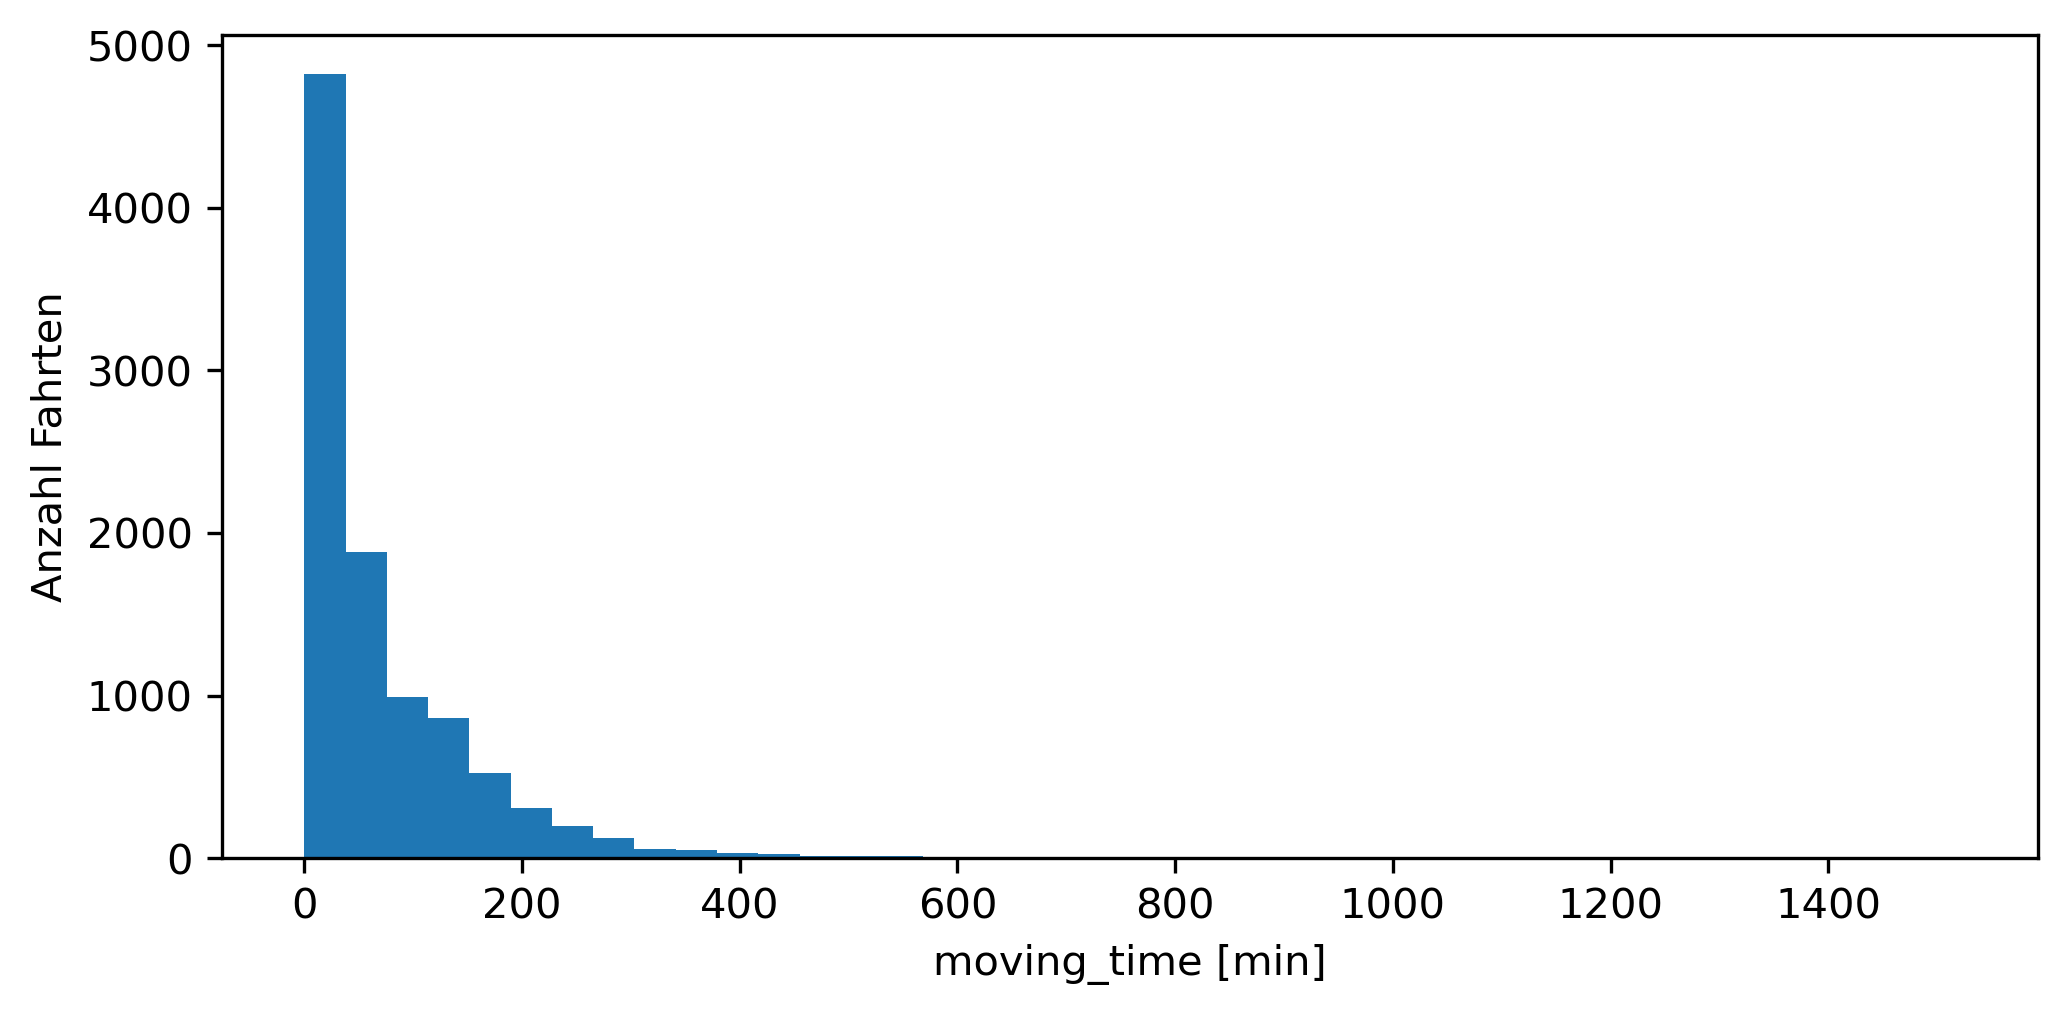

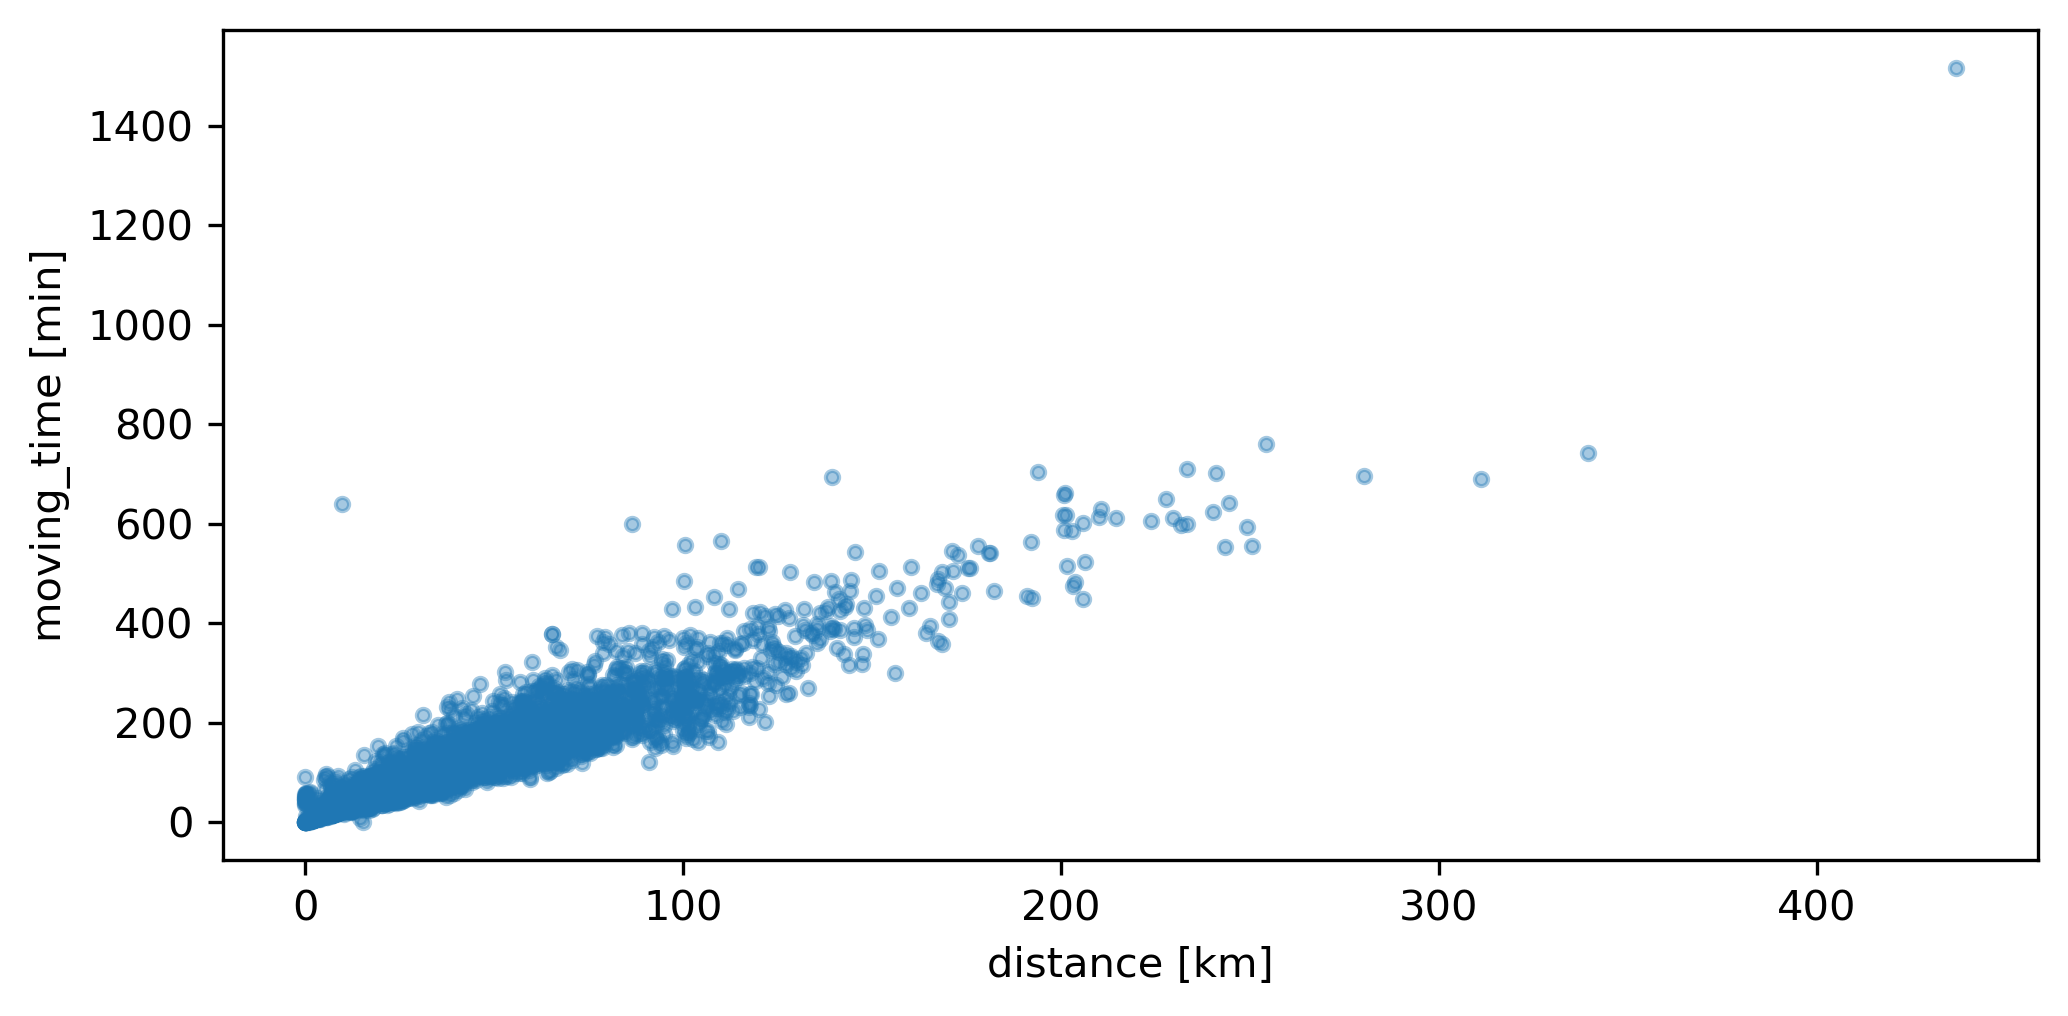

In [4]:
from IPython.display import Image, display

p_target = PATH_PLOTS / "01_target_distribution_moving_time_min.png"
p_scatter = PATH_PLOTS / "01_scatter_distance_km_vs_moving_time_min.png"

if p_target.exists():
    display(Image(filename=str(p_target)))
else:
    print("[WARN] Plot fehlt:", p_target, "→ wird neu erzeugt.")
    mt_min = processed["moving_time"] / 60.0
    plt.figure(figsize=(7, 3.5))
    plt.hist(mt_min, bins=40)
    plt.xlabel("moving_time [min]")
    plt.ylabel("Anzahl Fahrten")
    p = savefig(PATH_PLOTS / "08_target_distribution_moving_time_min.png")
    plt.show()
    print("Saved:", p)

if p_scatter.exists():
    display(Image(filename=str(p_scatter)))
else:
    print("[WARN] Plot fehlt:", p_scatter, "→ wird neu erzeugt.")
    distance_km = processed["distance"] / 1000.0 if processed["distance"].max() > 500 else processed["distance"]
    mt_min = processed["moving_time"] / 60.0
    plt.figure(figsize=(7, 3.5))
    plt.scatter(distance_km, mt_min, s=10, alpha=0.4)
    plt.xlabel("distance [km]")
    plt.ylabel("moving_time [min]")
    p = savefig(PATH_PLOTS / "08_scatter_distance_km_vs_moving_time_min.png")
    plt.show()
    print("Saved:", p)

In [5]:
corr_raw_path = PATH_DERIVED / "01_raw_corr_with_target.csv"
corr_raw = load_csv(corr_raw_path, "01_raw_corr_with_target.csv")

# Top 8 (nach absoluter Korrelation)
corr_top = corr_raw.copy()
corr_top["abs_corr"] = corr_top["corr_with_moving_time"].abs()
corr_top = corr_top.sort_values("abs_corr", ascending=False).drop(columns=["abs_corr"]).head(8).reset_index(drop=True)

display(corr_top)

out_path = PATH_DERIVED / "83_eda_top_correlations.csv"
corr_top.to_csv(out_path, index=False)
print("Saved:", out_path)

,feature,corr_with_moving_time
0,distance,0.951408
1,total_elevation_gain,0.790216
2,max_speed,0.485221
3,highest_elevation,0.393653
4,elapsed_time,0.318615
5,lowest_elevation,-0.037897
6,average_speed,-0.025275
7,age_group,0.020316


Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/83_eda_top_correlations.csv


## 4. Datenvorverarbeitung

Die Vorverarbeitung umfasst:
- Bereinigung und Auswahl von Kernspalten (`processed.csv`)
- Anwendung des Projekt-Scopes (nur Fahrten **≥ 5 km**)
- Feature Engineering zur Unterstützung nichtlinearer Modelle
- Qualitätschecks (QC), um offensichtliche Probleme früh sichtbar zu machen

Wichtig:
- `elapsed_time` bleibt als QC-Spalte im Datensatz, wird aber **nicht** als Feature in den Modellen verwendet (Leakage-Vermeidung).

In [6]:
scope_report = load_csv(PATH_DERIVED / "02_scope_filter_report.csv", "02_scope_filter_report.csv")
display(scope_report)

# Effekt des Scopes (wie viele Fahrten entfernt)
before_rows = int(scope_report.loc[scope_report["step"] == "load_processed", "rows"].iloc[0])
after_rows = int(scope_report.loc[scope_report["step"] == "scope_filter_distance_km_ge_5", "rows"].iloc[0])
removed = before_rows - after_rows

print(f"Scope (≥5 km): {before_rows} → {after_rows} Zeilen (entfernt: {removed}).")

out_path = PATH_DERIVED / "84_scope_summary.csv"
pd.DataFrame([{
    "processed_rows_before_scope": before_rows,
    "rows_after_scope_ge_5km": after_rows,
    "rows_removed": removed,
}]).to_csv(out_path, index=False)
print("Saved:", out_path)

,step,rows,removed
0,load_processed,9948,NaN
1,scope_filter_distance_km_ge_5,9237,711.0


Scope (≥5 km): 9948 → 9237 Zeilen (entfernt: 711).
Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/84_scope_summary.csv


In [7]:
fe_report = load_csv(PATH_DERIVED / "02_feature_engineering_report.csv", "02_feature_engineering_report.csv")
qc_summary = load_csv(PATH_DERIVED / "02_qc_summary_model_ready.csv", "02_qc_summary_model_ready.csv")

print("Feature Engineering (Übersicht):")
display(fe_report)

print("QC Summary (model_ready):")
display(qc_summary)

# Zusätzlich: Feature-Liste laden und Leakage-Spalten sichtbar machen
feat_list = load_csv(PATH_DERIVED / "02_feature_list_model_ready.csv", "02_feature_list_model_ready.csv")
leakage_present = feat_list[feat_list["feature"].isin(["elapsed_time"])].copy()

print("Leakage-Spalten in model_ready (dokumentiert):")
display(leakage_present)

out_path = PATH_DERIVED / "85_preprocessing_overview.csv"
pd.DataFrame([{
    "n_engineered_features": int(len(fe_report)),
    "model_ready_rows": int(qc_summary.loc[0, "n_rows"]),
    "model_ready_cols": int(qc_summary.loc[0, "n_cols"]),
    "missing_cells_total": int(qc_summary.loc[0, "missing_cells_total"]),
    "missing_rows_any": int(qc_summary.loc[0, "missing_rows_any"]),
}]).to_csv(out_path, index=False)
print("Saved:", out_path)

Feature Engineering (Übersicht):


,feature,definition
0,elev_range,highest_elevation - lowest_elevation
1,elev_gain_per_km,total_elevation_gain / distance_km
2,stop_time,elapsed_time - moving_time
3,stop_ratio,stop_time / elapsed_time
4,pace_min_per_km,(moving_time/60) / distance_km
5,avg_speed_implied_kmh,distance_km / (moving_time/3600)


QC Summary (model_ready):


,n_rows,n_cols,n_duplicates_all_cols,missing_cells_total,missing_rows_any,has_elapsed_time_col,target_col_present
0,9237,14,82,0,0,1,1


Leakage-Spalten in model_ready (dokumentiert):


,feature
4,elapsed_time


Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/85_preprocessing_overview.csv


## 5. Data Augmentation (optional)

Für dieses Projekt wurde **keine Data Augmentation** eingesetzt.

Begründung:
- Es handelt sich um tabellarische Aktivitätsdaten, bei denen synthetische Variation schnell zu unrealistischen Kombinationen führen kann.
- Der Schwerpunkt liegt auf nachvollziehbarer Vorverarbeitung, sauberer Evaluation und fundierter Diskussion (statt maximaler Performance).

Statt Data Augmentation wurden zur Robustheit eingesetzt:
- klarer Scope (≥ 5 km)
- Cross-Validation für Baselines
- strikte Trennung von Trainingsdaten und Hold-out bei Modellwahl und Tuning

## 6. Modellauswahl und -architektur

Es werden zwei Modellklassen gegenübergestellt:

**Baselines (no-leak):**
- Ridge Regression (linear, robust, gut interpretierbar)
- optional: polynomiale Features + Ridge (erhöht Flexibilität, bleibt kontrollierbar)

**Erweiterter Ansatz:**
- HistGradientBoostingRegressor (HistGBR): kann nichtlineare Zusammenhänge zwischen Distanz/Topografie und Fahrtdauer besser abbilden.

Die Modelle werden so gewählt, dass ein nachvollziehbarer Vergleich zwischen einem einfachen, stabilen Baseline-Modell und einem leistungsfähigeren nichtlinearen Modell möglich ist.

## 7. Training

Trainings- und Evaluationslogik:

1. **Cross-Validation** (nur Trainingsdaten) zur Auswahl einer Baseline-Konfiguration (Anforderung 8 vorbereitet).
2. **Hold-out Evaluation** als unabhängiger Leistungstest.
3. Für HistGBR: **Mini-Tuning ausschließlich auf dem Trainingssplit** per CV; der Hold-out bleibt bis zur finalen Evaluation unberührt.

Damit ist sichergestellt, dass die finale Bewertung nicht durch “Parameter-Entscheidungen auf dem Testset” verzerrt wird.

In [8]:
# Baseline CV Ergebnisse (Notebook 03)
cv = load_csv(PATH_DERIVED / "03_cv_results_final_no_leak.csv", "03_cv_results_final_no_leak.csv")
display(cv)

# Hold-out Baseline (Notebook 04) und HistGBR (Notebook 05)
m_base = load_csv(PATH_DERIVED / "04_holdout_metrics_no_leak.csv", "04_holdout_metrics_no_leak.csv")
m_hgbr = load_csv(PATH_DERIVED / "05_holdout_metrics_histgbr.csv", "05_holdout_metrics_histgbr.csv")
cmp = load_csv(PATH_DERIVED / "05_holdout_comparison_baseline_vs_histgbr.csv", "05_holdout_comparison_baseline_vs_histgbr.csv")

display(m_base)
display(m_hgbr)
display(cmp)

print("Baseline-Sieger (CV):", executive_summary.loc[0, "model"])
print("Hold-out Baseline:", executive_summary.loc[1, "model"])
print("Hold-out HistGBR:", executive_summary.loc[2, "model"])

,model,mae_mean,mae_std,rmse_mean,rmse_std,r2_mean,r2_std
0,"Ridge (degree=1, alpha=0.01) [BEST]",759.011044,18.484067,1464.133160,83.880510,0.918226,0.007980
1,Poly2 + Ridge (alpha=0.01),763.280154,16.236794,1462.786407,90.830843,0.918208,0.010345
2,Dummy (median),3239.355974,80.867454,5565.130071,170.746239,-0.179201,0.017479


,block,model,mae_s,rmse_s,r2,mae_min,rmse_min
0,Hold-out – Baseline (no-leak),"Ridge (degree=1, alpha=0.01)",746.736998,1603.895606,0.907417,12.445617,26.731593


,block,model,mae_s,rmse_s,r2,mae_min,rmse_min
0,"Hold-out – HistGBR (FE, train-tuned)",HistGBR depth=8 lr=0.05 it=300,583.1639,1412.42698,0.928202,9.719398,23.54045


,baseline_model,baseline_mae_s,histgbr_model,histgbr_mae_s,mae_improvement_s,mae_improvement_pct
0,"Ridge (degree=1, alpha=0.01)",746.736998,HistGBR depth=8 lr=0.05 it=300,583.1639,163.573098,21.905048


Baseline-Sieger (CV): Ridge (degree=1, alpha=0.01) [BEST]
Hold-out Baseline: Ridge (degree=1, alpha=0.01)
Hold-out HistGBR: HistGBR depth=8 lr=0.05 it=300


## 8. Evaluation und Ergebnisse

Die Evaluation erfolgt mit:
- **MAE** (Sekunden): gut interpretierbar als durchschnittlicher absoluter Fehler
- **RMSE** (Sekunden): stärker sensitiv gegenüber Ausreißern
- **R²**: Anteil erklärter Varianz

Im Folgenden werden Baseline (no-leak) und HistGBR direkt auf dem Hold-out Datensatz verglichen.

In [9]:
m_base = load_csv(PATH_DERIVED / "04_holdout_metrics_no_leak.csv", "04_holdout_metrics_no_leak.csv")
m_hgbr = load_csv(PATH_DERIVED / "05_holdout_metrics_histgbr.csv", "05_holdout_metrics_histgbr.csv")
cmp = load_csv(PATH_DERIVED / "05_holdout_comparison_baseline_vs_histgbr.csv", "05_holdout_comparison_baseline_vs_histgbr.csv")

comparison_table = pd.DataFrame([
    {
        "block": "Hold-out Baseline (no-leak)",
        "model": str(m_base.loc[0, "model"]),
        "mae_s": float(m_base.loc[0, "mae_s"]),
        "rmse_s": float(m_base.loc[0, "rmse_s"]),
        "r2": float(m_base.loc[0, "r2"]),
        "mae_min": float(m_base.loc[0, "mae_s"]/60.0),
    },
    {
        "block": "Hold-out HistGBR",
        "model": str(m_hgbr.loc[0, "model"]),
        "mae_s": float(m_hgbr.loc[0, "mae_s"]),
        "rmse_s": float(m_hgbr.loc[0, "rmse_s"]),
        "r2": float(m_hgbr.loc[0, "r2"]),
        "mae_min": float(m_hgbr.loc[0, "mae_s"]/60.0),
    },
])

display(comparison_table)
display(cmp)

out_path = PATH_DERIVED / "86_eval_holdout_comparison.csv"
comparison_table.to_csv(out_path, index=False)
print("Saved:", out_path)

,block,model,mae_s,rmse_s,r2,mae_min
0,Hold-out Baseline (no-leak),"Ridge (degree=1, alpha=0.01)",746.736998,1603.895606,0.907417,12.445617
1,Hold-out HistGBR,HistGBR depth=8 lr=0.05 it=300,583.163900,1412.426980,0.928202,9.719398


,baseline_model,baseline_mae_s,histgbr_model,histgbr_mae_s,mae_improvement_s,mae_improvement_pct
0,"Ridge (degree=1, alpha=0.01)",746.736998,HistGBR depth=8 lr=0.05 it=300,583.1639,163.573098,21.905048


Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/86_eval_holdout_comparison.csv


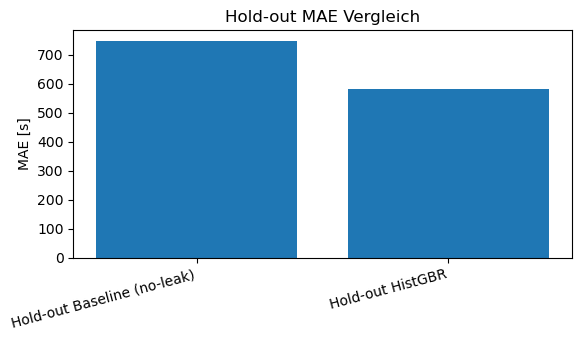

Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/plots/08_holdout_mae_comparison.png
HistGBR verbessert den Hold-out MAE um 164s (21.9%).


In [10]:
plt.figure(figsize=(6, 3.5))
plt.bar(comparison_table["block"], comparison_table["mae_s"])
plt.ylabel("MAE [s]")
plt.title("Hold-out MAE Vergleich")
plt.xticks(rotation=15, ha="right")

plot_path = savefig(PATH_PLOTS / "08_holdout_mae_comparison.png", dpi=300)
plt.show()
print("Saved:", plot_path)

# Kurze Interpretation als Text-Output (prüfbar)
impr_s = float(cmp.loc[0, "mae_improvement_s"])
impr_pct = float(cmp.loc[0, "mae_improvement_pct"])
print(f"HistGBR verbessert den Hold-out MAE um {impr_s:.0f}s ({impr_pct:.1f}%).")

### 8.1 Interpretability: Permutation Importance (HistGBR)

Permutation Importance misst den Leistungsabfall, wenn ein Feature zufällig permutiert wird.
Hier ist der Wert als **MAE-Anstieg** (Sekunden) definiert:

- **positiv** → MAE wird schlechter → Feature ist wichtig
- **nahe 0** → Feature trägt in diesem Setup kaum zusätzliche Information

,feature,mae_increase_s,mae_increase_std_s
0,distance,3.595260e+03,5.686223e+01
1,total_elevation_gain,4.148155e+02,1.096061e+01
2,highest_elevation,1.468966e+02,7.538070e+00
3,lowest_elevation,1.462370e+02,1.045634e+01
4,elev_range,1.126343e+02,4.953345e+00
5,elev_gain_per_km,1.069435e+02,7.548858e+00
6,distance_km,-1.136868e-13,1.166402e-13


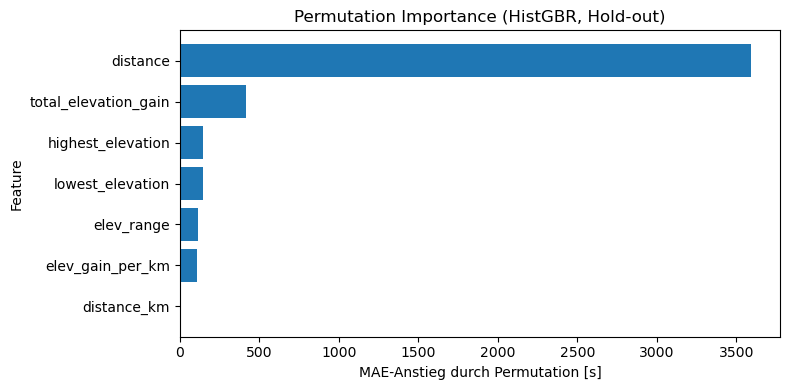

Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/plots/08_permutation_importance_histgbr.png
Top-Treiber: distance > total_elevation_gain > highest_elevation


In [11]:
pi = load_csv(PATH_DERIVED / "06_permutation_importance_histgbr.csv", "06_permutation_importance_histgbr.csv")
display(pi)

# Plot
pi_sorted = pi.sort_values("mae_increase_s", ascending=True)  # für barh: klein oben, groß unten
plt.figure(figsize=(8, 4))
plt.barh(pi_sorted["feature"], pi_sorted["mae_increase_s"])
plt.xlabel("MAE-Anstieg durch Permutation [s]")
plt.ylabel("Feature")
plt.title("Permutation Importance (HistGBR, Hold-out)")
plot_path = savefig(PATH_PLOTS / "08_permutation_importance_histgbr.png", dpi=300)
plt.show()
print("Saved:", plot_path)

top3 = pi.sort_values("mae_increase_s", ascending=False).head(3)
print("Top-Treiber:", " > ".join(top3["feature"].tolist()))

In [12]:
pred = load_csv(PATH_DERIVED / "05_holdout_predictions_histgbr.csv", "05_holdout_predictions_histgbr.csv")
print("predictions geladen:", pred.shape)

required_cols = ["y_true", "y_pred", "distance"]
missing = [c for c in required_cols if c not in pred.columns]
if missing:
    raise ValueError(f"[ERROR] Erwartete Spalten fehlen in 05_holdout_predictions_histgbr.csv: {missing}")

pred = pred.copy()
pred["abs_error_s"] = (pred["y_true"] - pred["y_pred"]).abs()

# distance_km (für Plots/Buckets)
pred["distance_km"] = pred["distance"] / 1000.0 if pred["distance"].max() > 500 else pred["distance"]

stats = pred["abs_error_s"].describe(percentiles=[0.5, 0.9, 0.95, 0.99]).to_frame().T
stats["abs_error_min_mean"] = pred["abs_error_s"].mean() / 60.0
display(stats)

stats_path = PATH_DERIVED / "87_error_stats_abs_error.csv"
stats.to_csv(stats_path, index=False)
print("Saved:", stats_path)

predictions geladen: (1848, 10)


,count,mean,std,min,50%,90%,95%,99%,max,abs_error_min_mean
abs_error_s,1848.0,583.1639,1286.765642,0.08885,220.733331,1430.635737,2430.157088,4787.341739,36091.039592,9.719398


Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/87_error_stats_abs_error.csv


### 8.2 Fehleranalyse (Hold-out, HistGBR)

Ziel der Fehleranalyse ist es, systematische Schwächen zu identifizieren:
- Wie hängt der absolute Fehler mit der Distanz zusammen?
- In welchen Distanzbereichen steigen Median/Mean/Quantile des Fehlers?


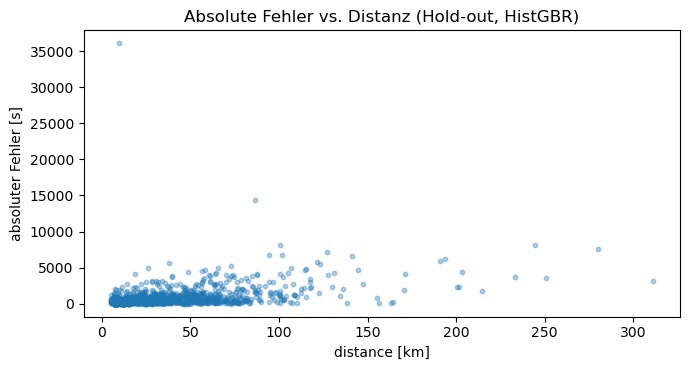

Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/plots/08_abs_error_vs_distance_scatter.png


In [13]:
plt.figure(figsize=(7, 3.8))
plt.scatter(pred["distance_km"], pred["abs_error_s"], s=10, alpha=0.35)
plt.xlabel("distance [km]")
plt.ylabel("absoluter Fehler [s]")
plt.title("Absolute Fehler vs. Distanz (Hold-out, HistGBR)")

plot_path = savefig(PATH_PLOTS / "08_abs_error_vs_distance_scatter.png", dpi=300)
plt.show()
print("Saved:", plot_path)

In [14]:
# Distanz-Buckets (Scope startet bei >=5 km)
bins = [5, 10, 20, 40, 80, np.inf]
labels = ["5–10", "10–20", "20–40", "40–80", "80+"]

pred["distance_bucket_km"] = pd.cut(
    pred["distance_km"],
    bins=bins,
    labels=labels,
    right=False,  # [a,b)
    include_lowest=True,
)

# FutureWarning vermeiden: observed=True
bucket = (
    pred.groupby("distance_bucket_km", observed=True)["abs_error_s"]
    .agg(
        count="count",
        median="median",
        mean="mean",
        p90=lambda s: float(np.quantile(s, 0.90)),
    )
    .reset_index()
)

display(bucket)

out_path = PATH_DERIVED / "88_error_buckets_by_distance.csv"
bucket.to_csv(out_path, index=False)
print("Saved:", out_path)

print("Hinweis: Steigende Fehlerkennzahlen mit Distanz deuten auf höhere Varianz/Unsicherheit bei langen Fahrten hin.")


,distance_bucket_km,count,median,mean,p90
0,5–10,615,92.073002,216.435727,312.283348
1,10–20,450,186.597074,293.627592,637.730854
2,20–40,368,391.571047,632.715147,1400.462343
3,40–80,303,705.429571,1023.207579,2562.291676
4,80+,112,1722.281627,2406.923467,5402.053290


Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/88_error_buckets_by_distance.csv
Hinweis: Steigende Fehlerkennzahlen mit Distanz deuten auf höhere Varianz/Unsicherheit bei langen Fahrten hin.


## 9. Diskussion und Fazit

### Diskussion (Einordnung der Ergebnisse)

**Ergebnis:** Das nichtlineare HistGBR-Modell reduziert den Hold-out MAE deutlich gegenüber der Baseline (Ridge).  
Damit spricht der Datensatz für nichtlineare Zusammenhänge zwischen Distanz/Topografie und Fahrtdauer, die durch Boosting besser erfasst werden.

**Treiber:** Die Permutation Importance zeigt klar, dass `distance` dominiert; topografische Größen (z. B. `total_elevation_gain`) liefern zusätzliche Information.

**Fehlerbild:** Die Fehleranalyse nach Distanz-Buckets zeigt, dass Median/Mean/P90 des Fehlers mit der Distanz steigen. Das ist fachlich plausibel (größere Heterogenität langer Fahrten durch Pausen, Routing, Verpflegung, Gruppenfahrten und Trackingeffekte).

### Limitationen

1. **Fehlende erklärende Variablen:** Wetter (Wind/Temperatur), Verkehr/Untergrund, Fitnesszustand, Fahrradtyp und Fahrstil sind nicht enthalten.
2. **Heterogenität langer Fahrten:** Bei langen Distanzen steigt die Varianz durch Stopps, Routenwahl und Kontextfaktoren.
3. **Tracking- und Messartefakte:** GPS-Rauschen, unterschiedliche Samplingraten und Stop-Erkennung können Ausreißer erzeugen.
4. **Generalisierbarkeit:** Der Datensatz repräsentiert ein spezifisches Nutzer-/Kontextprofil; Übertragbarkeit ist nicht garantiert.

### Next Steps

1. Feature-Erweiterung (z. B. Wetter, Tageszeit/Wochentag, Routen-/Untergrundindikatoren).
2. Robustere Evaluation (wiederholte Splits; ggf. gruppierte Splits nach `hashed_id`, falls verfügbar).
3. Erweiterte Fehlermaße (zusätzlich relative Fehler oder distanz-normalisierte Fehler).
4. Unsicherheitsabschätzung (Prediction Intervals / Quantile-Ansätze).
5. Ausbau der QC-Pipeline (Regeln für Ausreißerfälle dokumentieren und automatisieren).

In [15]:
impr_s = float(cmp.loc[0, "mae_improvement_s"])
impr_pct = float(cmp.loc[0, "mae_improvement_pct"])

top3 = pi.sort_values("mae_increase_s", ascending=False).head(3)["feature"].tolist()

# Kennzahlen aus Bucket-Tabelle
worst_bucket = bucket.sort_values("p90", ascending=False).iloc[0]
worst_label = str(worst_bucket["distance_bucket_km"])
worst_p90 = float(worst_bucket["p90"])

print("FAZIT (Kernpunkte):")
print(f"- Hold-out: HistGBR verbessert den MAE um {impr_s:.0f}s ({impr_pct:.1f}%) gegenüber der Baseline.")
print(f"- Wichtigste Treiber (Permutation Importance): {top3[0]} > {top3[1]} > {top3[2]}.")
print(f"- Fehler steigen mit Distanz; größter P90 im Bucket '{worst_label}' (P90 ≈ {worst_p90:.0f}s).")
print("- Leakage-Vermeidung: 'elapsed_time' ist dokumentiert, wird aber nicht als Feature verwendet.")
print("- Nächste Schritte: Feature-Erweiterung, robustere Evaluation, Unsicherheitsabschätzung, QC-Ausbau.")

# (Optional) Liste wichtiger erzeugter Report-Artefakte
report_artifacts = [
    PATH_DERIVED / "80_executive_summary.csv",
    PATH_DERIVED / "82_leakage_cols_present.csv",
    PATH_DERIVED / "83_eda_top_correlations.csv",
    PATH_DERIVED / "84_scope_summary.csv",
    PATH_DERIVED / "85_preprocessing_overview.csv",
    PATH_DERIVED / "86_eval_holdout_comparison.csv",
    PATH_DERIVED / "87_error_stats_abs_error.csv",
    PATH_DERIVED / "88_error_buckets_by_distance.csv",
    PATH_PLOTS / "08_holdout_mae_comparison.png",
    PATH_PLOTS / "08_permutation_importance_histgbr.png",
    PATH_PLOTS / "08_abs_error_vs_distance_scatter.png",
]

print("\nWichtige Report-Artefakte:")
for p in report_artifacts:
    print("-", p.name, "| exists:", p.exists())

FAZIT (Kernpunkte):
- Hold-out: HistGBR verbessert den MAE um 164s (21.9%) gegenüber der Baseline.
- Wichtigste Treiber (Permutation Importance): distance > total_elevation_gain > highest_elevation.
- Fehler steigen mit Distanz; größter P90 im Bucket '80+' (P90 ≈ 5402s).
- Leakage-Vermeidung: 'elapsed_time' ist dokumentiert, wird aber nicht als Feature verwendet.
- Nächste Schritte: Feature-Erweiterung, robustere Evaluation, Unsicherheitsabschätzung, QC-Ausbau.

Wichtige Report-Artefakte:
- 80_executive_summary.csv | exists: True
- 82_leakage_cols_present.csv | exists: True
- 83_eda_top_correlations.csv | exists: True
- 84_scope_summary.csv | exists: True
- 85_preprocessing_overview.csv | exists: True
- 86_eval_holdout_comparison.csv | exists: True
- 87_error_stats_abs_error.csv | exists: True
- 88_error_buckets_by_distance.csv | exists: True
- 08_holdout_mae_comparison.png | exists: True
- 08_permutation_importance_histgbr.png | exists: True
- 08_abs_error_vs_distance_scatter.png | ex